In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist['data'].to_numpy(), mnist['target'].to_numpy()
(X.shape, y.shape)

((70000, 784), (70000,))

In [5]:
type(X)

numpy.ndarray

### Visualizing data

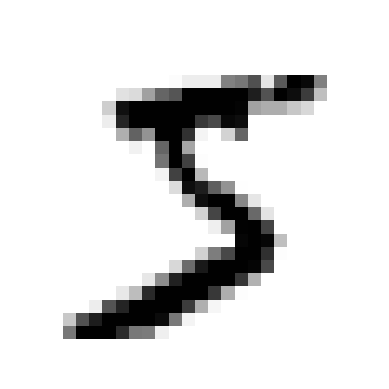

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [7]:
import numpy as np 
y = y.astype(np.uint8)
y[2]

4

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Binary classifier of 5

In [9]:
y_train_5 =(y_train==5)
y_test_5 =(y_test==5)

In [10]:
## Classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([X_train[0],X_train[0]])

array([ True,  True])

### Cross validation using custom KFold

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


In [13]:
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [14]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred==y_test_folds)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


### Same Cross Validation with Sklearn

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')


array([0.95035, 0.96035, 0.9604 ])

In [16]:
from sklearn.base import BaseEstimator

In [17]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()

In [18]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### Confusion matrix 

In [19]:
from sklearn.model_selection import cross_val_predict

In [20]:
y_train_5_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
len(y_train_5_pred), y_train_5_pred.shape, y_train_5_pred[:2]

(60000, (60000,), array([ True, False]))

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
real_cfm = confusion_matrix(y_train_5, y_train_5_pred)
real_cfm

array([[53892,   687],
       [ 1891,  3530]])

In [24]:
perfect_pred_y5 = y_train_5
perfect_cfm = confusion_matrix(y_train_5, perfect_pred_y5)
perfect_cfm

array([[54579,     0],
       [    0,  5421]])

In [25]:
precision = real_cfm[1][1] / (real_cfm[1][1] + real_cfm[0][1])
recall = real_cfm[1][1] / (real_cfm[1][1] + real_cfm[1][0])
print("precision = (" , real_cfm[1][1] , "/ ", real_cfm[1][1], "+", real_cfm[0][1] , ") = ",precision)
print("recall = (" , real_cfm[1][1] , "/ ", real_cfm[1][1], "+", real_cfm[1][0] , ") = ", recall)

precision = ( 3530 /  3530 + 687 ) =  0.8370879772350012
recall = ( 3530 /  3530 + 1891 ) =  0.6511713705958311


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_skl = precision_score(y_train_5, y_train_5_pred)
recall_skl = recall_score(y_train_5, y_train_5_pred)
f1_score_skl = f1_score(y_train_5, y_train_5_pred)
print('precision = ',precision_skl,'recall =',recall_skl, 'f1_score = ', f1_score_skl)

precision =  0.8370879772350012 recall = 0.6511713705958311 f1_score =  0.7325171197343846


In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [28]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
len(thresholds), len(precisions), len(y_train_5)

(60000, 60001, 60000)

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend(loc='center right', fontsize=16)
    plt.grid(True)
    plt.axis([-50000,50000,0,1])
    

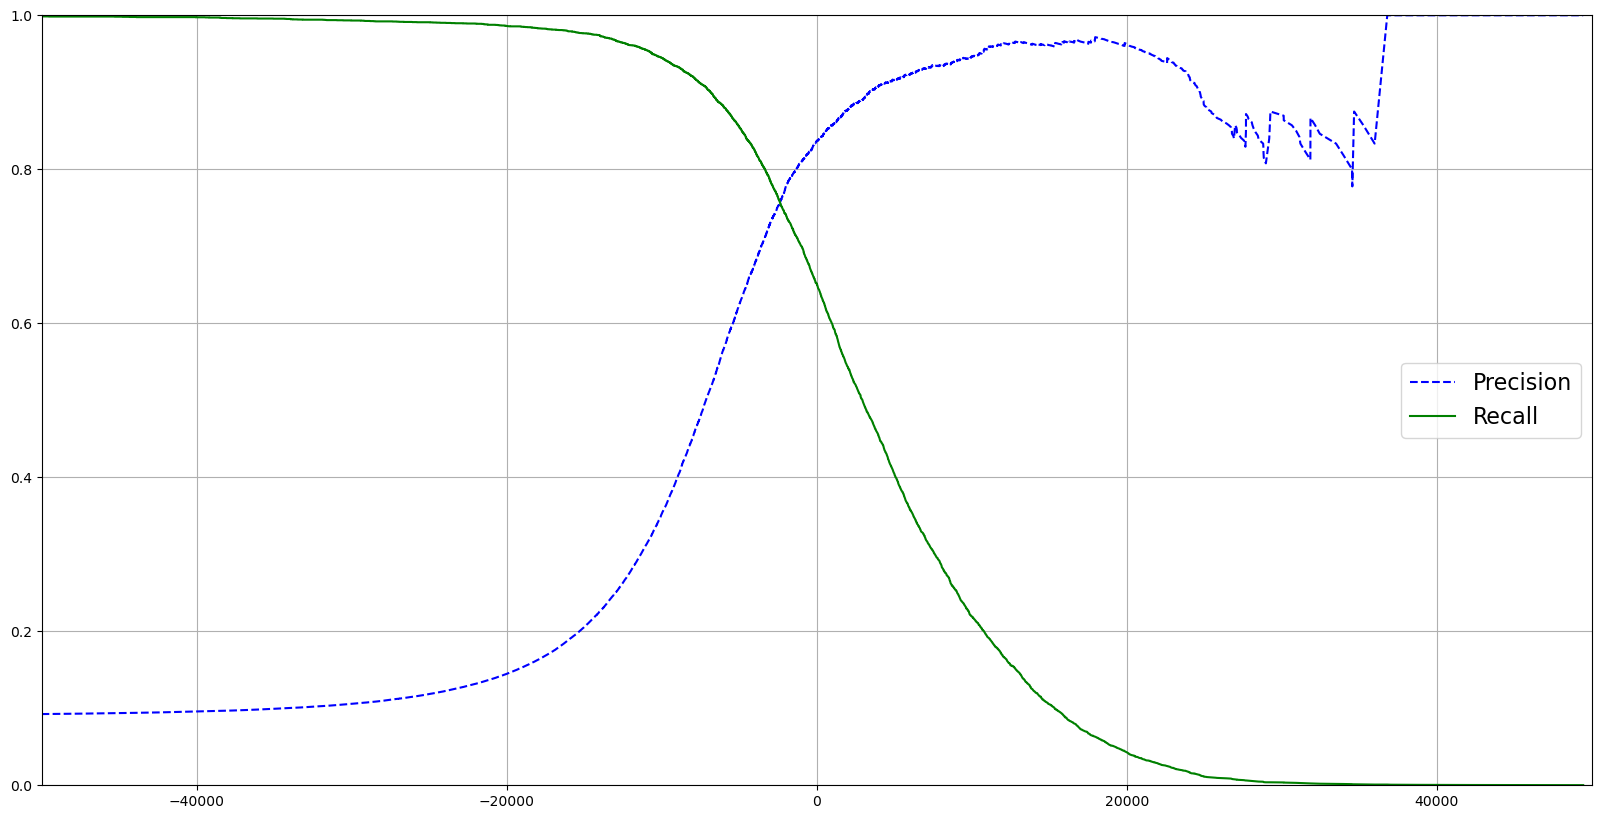

In [30]:
plt.figure(figsize=(20,10))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

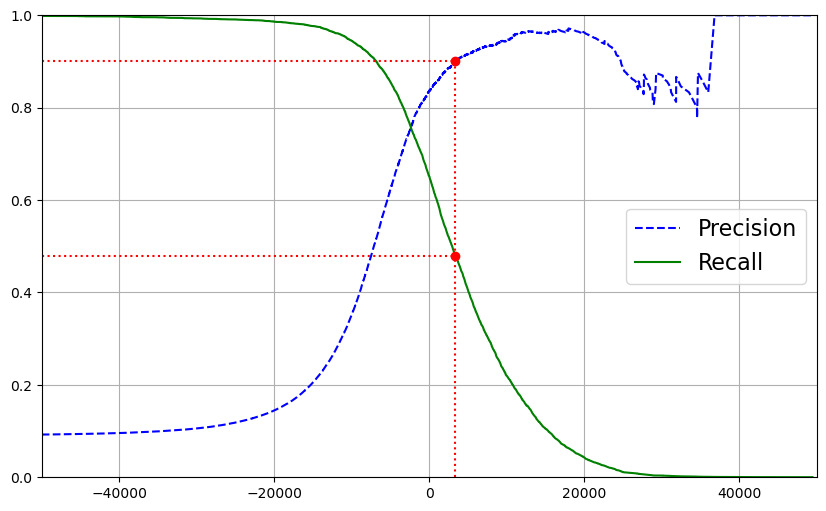

In [31]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
recall_90_precision, threshold_90_precision
plt.figure(figsize=(10,6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0,.9],"r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")  
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
                                              # Not shown
plt.show()

In [32]:
y_train_pred_90 =(y_scores >= threshold_90_precision)

precision_scr = precision_score(y_train_5, y_train_pred_90)
recall_scr = recall_score(y_train_5, y_train_pred_90)
precision_scr, recall_scr


(0.9000345901072293, 0.4799852425751706)

### Precision vs recall tradeoff graph

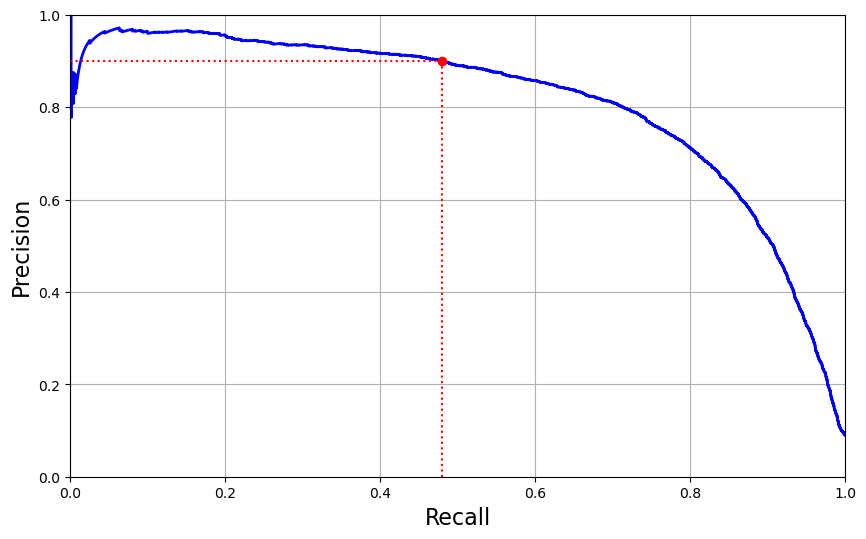

In [33]:
plt.figure(figsize=(10,6))
plt.plot(recalls, precisions,  "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

### ROC Curve( TPR vs FPR)

In [34]:
from sklearn.metrics import roc_curve

In [35]:
fpr,tpr, thresholds = roc_curve(y_train_5,y_scores)
tpr[10], fpr[10], thresholds[10]

(0.006271905552481092, 9.161032631598233e-05, 27687.178595082736)

In [36]:
def plot_roc_curve(fpr,tpr, labels=None):
    plt.plot(fpr,tpr, linewidth=2)
    plt.plot([0,1],[0,1], "k--")
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.axis([0,1, 0, 1])
    plt.grid(True)

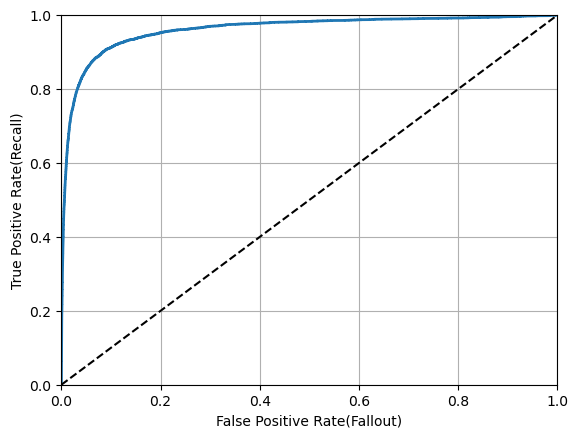

<Figure size 1000x600 with 0 Axes>

In [37]:
plot_roc_curve(fpr, tpr, labels=['False Positive Rate(Fallout)', 'True Positive Rate(Recall)'])
plt.figure(figsize=(10,6))
plt.show()


In [38]:
from sklearn.metrics import roc_auc_score

In [39]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Precision vs recall is preferred when the positive class is rare (imbalance class), AuC is used otherwise

### ROC Curve of two classifers

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
forest_clf = RandomForestClassifier(random_state=42)

In [42]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [43]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

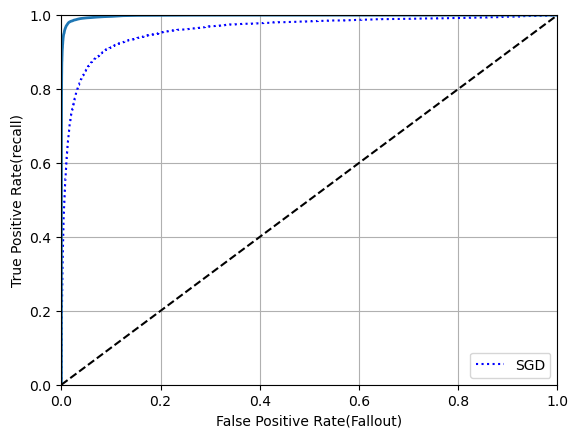

In [44]:

plt.plot(fpr, tpr, "b:",label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, labels=["False Positive Rate(Fallout)", "True Positive Rate(recall)"])
plt.legend(loc="lower right")
plt.show()

In [45]:
auc_score = roc_auc_score(y_train_5, y_scores_forest)
auc_score

0.9983436731328145

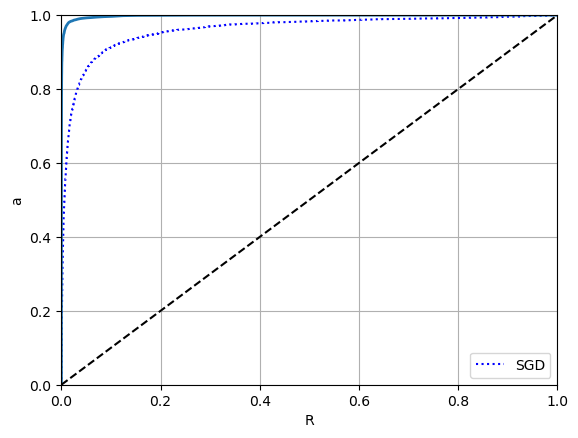

In [46]:
plt.plot(fpr, tpr, ":b",label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [47]:
np.argmax(y_scores_forest>=0.90)
roc_auc_score(y_train_5, y_scores_forest)
#precision = precision_score(y_train_5, np.argmax[y_pred_forest])

0.9983436731328145

## Multiclassification

## OvA( One versus All)
10 classifier for 10 digits, select the highest score per prediction


In [48]:
from sklearn.multiclass import OneVsRestClassifier
ova = OneVsRestClassifier(SGDClassifier(random_state=42))
ova.fit(X_train[:300], y_train[:300])


OneVsRestClassifier(estimator=SGDClassifier(random_state=42))

In [49]:
ova.predict([some_digit])

array([5], dtype=uint8)

In [50]:
len(ova.estimators_), ova.classes_

(10, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [51]:
# gets the index of the class with highest score
np.argmax(ova.decision_function([some_digit]))

5

### OvO(One Versus One)
N/(N-1)/2 estimators

In [52]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train[:300], y_train[:300])

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [53]:
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [54]:
len(ovo_clf.estimators_), ovo_clf.classes_

(45, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [55]:
forest_clf.fit(X_train[:300], y_train[:300])
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [56]:
forest_clf.predict_proba([some_digit])

array([[0.03, 0.03, 0.  , 0.17, 0.01, 0.66, 0.01, 0.03, 0.02, 0.04]])

### Evaluating classifier using cross_validation score

In [57]:
cross_val_score(sgd_clf, X_train[:300], y_train[:300], cv=3, scoring="accuracy")

array([0.8 , 0.77, 0.79])

In [58]:
cross_val_score(forest_clf, X_train[:300], y_train[:300], cv=3, scoring="accuracy")

array([0.79, 0.84, 0.79])

### Same scores with scaled inputs

In [59]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled_300 = scaler.fit_transform(X_train[:300].astype(np.float64))

In [60]:
cross_val_score(sgd_clf, X_train_scaled_300, y_train[:300], cv=3, scoring="accuracy")

array([0.78, 0.78, 0.73])

In [61]:
cross_val_score(forest_clf, X_train_scaled_300, y_train[:300], cv=3, scoring="accuracy")

array([0.79, 0.84, 0.79])

## Error Analysis

In [62]:
X_train_scaled = scaler.fit_transform(X_train)

In [63]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [64]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

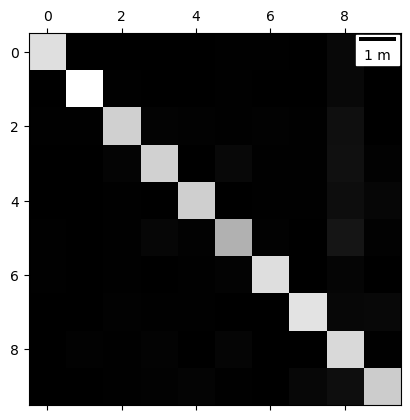

In [67]:
from matplotlib_scalebar.scalebar import ScaleBar
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.gca().add_artist(ScaleBar(1.0))
plt.show()

### Comparing predicted(columns) images against available images per classes(rows)

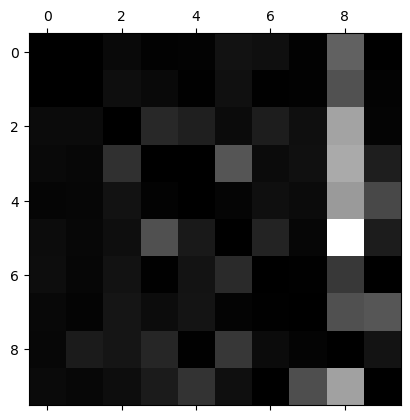

In [68]:
rows_sum = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx / rows_sum
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### Plotting different images classes(3,5)

In [69]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train== cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train== cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train== cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train== cl_b) & (y_train_pred == cl_b)]

In [70]:

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

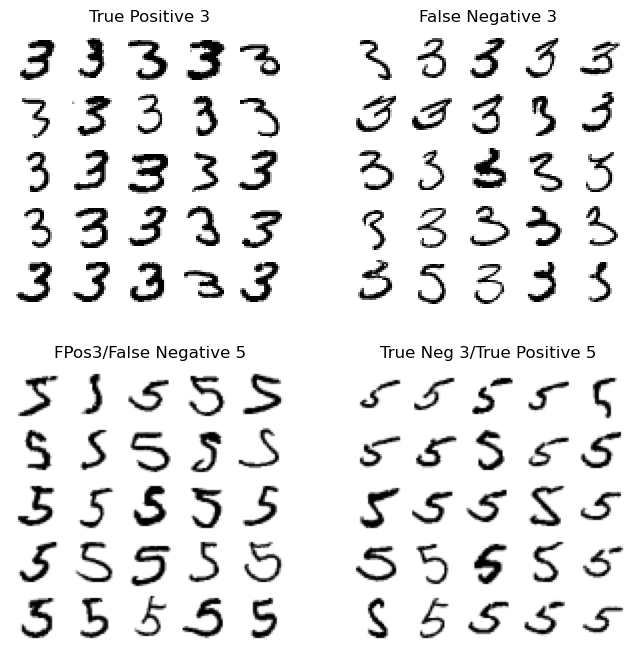

In [71]:
plt.figure(figsize=(8,8))
plt.subplot(221);plt.title("True Positive 3");plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222);plt.title("False Negative 3");plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223);plt.title("FPos3/False Negative 5");plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224);plt.title("True Neg 3/True Positive 5");plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel  Classification


In [72]:
from sklearn.neighbors import KNeighborsClassifier

In [73]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [74]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [75]:
knn_clf.predict([some_digit])

array([[False,  True]])

### Evaluating each prediction

In [76]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [77]:
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

In [78]:
### Weighted labels(each label is assigned multiplied by the ratio of its instance in the training set)
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9778357403921755

## Multi output classification
Predicting Pixel Values given an image + noise

In [79]:
noise_train = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise_train
noise_test = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise_test
y_train_mod = X_train
y_test_mod = X_test

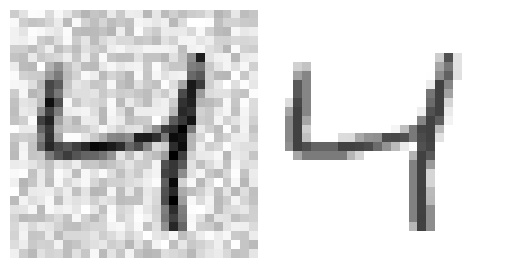

In [80]:
# left is a 4 with noise, right is a 4 without
plot_digits([X_train_mod[2], X_train[2]])

In [81]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [82]:
clean_digit = knn_clf.predict([X_test_mod[2]])

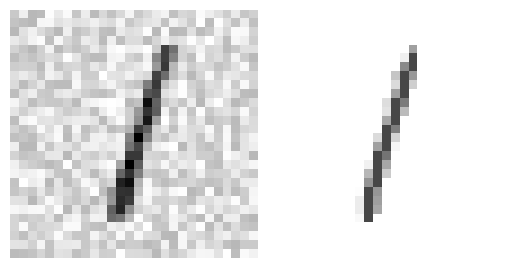

In [83]:
plot_digits([X_test_mod[2],clean_digit])